In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import ast
from typing import List
from spacy.lang.en import English
from tqdm.notebook import tqdm
from copy import deepcopy
from itertools import repeat
from functools import partial
from numpy.random import default_rng

import re

pd.options.display.max_columns = 300
pd.options.display.max_colwidth = 200
pd.options.display.min_rows = 200
pd.options.display.max_rows = 200


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filePath = os.path.join(dirname, filename)
        fileCsv = pd.read_csv(filePath)
        
        display(filePath)
        display(fileCsv.head())
        display(fileCsv.shape)

        variable = Path(filename).stem
        exec(f'data_{variable} = fileCsv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv'

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


(5, 2)

'/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv'

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began ..."
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness,..."
2,2,0,Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He can...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING...
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catchin..."


(42146, 3)

'/kaggle/input/nbme-score-clinical-patient-notes/features.csv'

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


(143, 3)

'/kaggle/input/nbme-score-clinical-patient-notes/train.csv'

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


(14300, 6)

'/kaggle/input/nbme-score-clinical-patient-notes/test.csv'

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


(5, 4)

# Objectives  

`id = {00016_001}`
Given the patient (pn_num=16)(look for the corresponding patient history notes), with specified feature needed (feat_num=001). Identify the target `position`, which is the (start, stop) index of the string that is related to the interested feature.  

# EDA

In [3]:
a = data_features.groupby('case_num').feature_text.apply(lambda series: series.value_counts()).reset_index()
display(a.head())
a.shape
# the number of features is still 143 rows. 
# this suggest one feature cannot appear in more than 1 case
# thus case_num can be used to select the candiate for the features

,case_num,level_1,feature_text
0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,1
1,0,Family-history-of-thyroid-disorder,1
2,0,Chest-pressure,1
3,0,Intermittent-symptoms,1
4,0,Lightheaded,1


(143, 3)

In [4]:
# the count of features in each case_num
# looks almost evenly distributed
data_features.groupby('case_num').feature_text.apply(len)

case_num
0    13
1    13
2    17
3    16
4    10
5    18
6    12
7     9
8    18
9    17
Name: feature_text, dtype: int64

## `patient_notes.csv` and `train.csv`
There are 42,146 notes, and 14,300 rows of labelled data

In [5]:
'unique patients in notes', len(data_patient_notes.pn_num.unique())

('unique patients in notes', 42146)

In [6]:
'patients in train data', len(data_train.pn_num.unique()) # 1000 patients in the training notes

('patients in train data', 1000)

In [7]:
# can a patient be in different case?
'number of patients having more than one case', sum(data_train.groupby('pn_num').case_num.apply(lambda series: len(series.unique())) > 1)

('number of patients having more than one case', 0)

In [8]:
patientInTrain = data_train.pn_num
data_patient_notes.pn_num.isin(patientInTrain).sum() # all thousand notes found
# with 14k notes, only 1000 notes comes with information annotation

1000

In [9]:
display(data_patient_notes.head())
display(data_patient_notes.shape)


data_train = pd.merge(data_train, data_features,
                      on='feature_num', how='left',
                      suffixes=('', '_duplicate')
                     )
data_train = data_train.loc[:,~data_train.columns.str.endswith('_duplicate')]
display(data_train.head())
display(data_train.shape)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began ..."
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness,..."
2,2,0,Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He can...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING...
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catchin..."


(42146, 3)

,id,case_num,pn_num,feature_num,annotation,location,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded


(14300, 7)

In [10]:
data_train = pd.merge(data_train, data_patient_notes,
                     on=['pn_num', 'case_num'])

In [11]:
print(data_train.shape, 'total number of data entry')
print(len(data_train.pn_history.unique()), 'unique number of patient notes')

(14300, 8) total number of data entry
1000 unique number of patient notes


<AxesSubplot:ylabel='Frequency'>

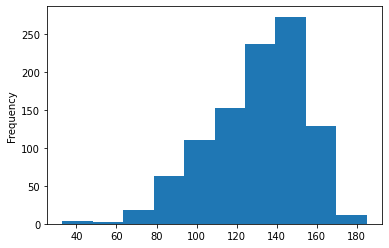

In [12]:
pd.Series(data_train.pn_history.unique()).str.count(' ').plot.hist()

EDA Questions:
* for each note(patient), how many labels are present in the text
* for each note(patient), what is the len of the text(char and token count)
* for every annotation, what is the distribution of char/token count of the text (some feature might need more words to describe)

In [13]:
data_train['annotationParsed'] = data_train.annotation.apply(lambda anno: ast.literal_eval(anno))

In [14]:
data_train[data_train.location.str.contains(';')].head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotationParsed
48,00082_009,0,82,9,"['heart pounding', 'heart racing', 'heart pounding']","['85 99', '126 138', '126 131;143 151']",heart-pounding-OR-heart-racing,17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[heart pounding, heart racing, heart pounding]"
91,00211_000,0,211,0,['Father MI'],['682 688;695 697'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...",[Father MI]
96,00211_005,0,211,5,['Denies sweating'],['462 468;473 481'],No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...",[Denies sweating]
100,00211_009,0,211,9,"['palpitations', 'Palpitations', 'palpitations', 'heart is pounding', 'heart is fast']","['40 52', '55 67', '104 116', '161 178', '161 169;179 183']",heart-pounding-OR-heart-racing,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...","[palpitations, Palpitations, palpitations, heart is pounding, heart is fast]"
125,00225_008,0,225,8,"['drinks coffee', 'drinks energy drinks']","['461 467;483 489', '461 467;506 519']",Caffeine-use,"17 y/o previously healthy male here with heart pounding. States a few months ago, he started having episodes of feeling like his heart is pound/jumping out of his chest. Denies any anxiety, sweati...","[drinks coffee, drinks energy drinks]"


In [15]:
data_train.loc[125, 'pn_history'][461:519]

'drinks about 3-4 cups coffee/day and several energy drinks'

## location explained

for each `pn_history` note, it could be queried on multiple `feature_text`, the response of the query is in the following format:  ['a b', 'c d;f g']  

This means that, span [a b], is the index of the first string,  
[c d; f g]   is the separate span for two strings  

The pre-processing of this step here is to convert a location to a a list of non-repeated, non-overlapping indices that is consistent with the ground truth.  

Given:  ['2 5', '6 8; 10 13', '7 10']  
return: ['2 5', '6 13']  


In [16]:
def parseLocation(location:str):
    locationStr = re.sub('\s{2,}', ' ', location)
    location : List[str] = ast.literal_eval(locationStr) # becomes a list of strings
    if not location:
        return location
    
    temp = []
    while location:
        spans = location.pop(0).split(';')
        for eachSpan in spans:
            start, end = eachSpan.split(' ')
            temp.append([int(start), int(end)])
    temp.sort()
    location = temp # converted the content to integer tuples

    temp=[] # linearise the index in the list
    temp.append(location.pop(0))
    while location:
        start, end = location.pop(0)

        if start == temp[-1][1]: # if the start is the end(exclusive) of last span
            temp[-1][1] = end # extend the end of the last span
        elif start > temp[-1][1]: # if the start is greater than end(exclusive) of last span
            temp.append([start, end])  
        elif start < temp[-1][1] and end > temp[-1][1]:
            temp[-1][1] = end # extend the end of the last span
        elif start < temp[-1][1] and end <= temp[-1][1]:
            continue
        else:
            print(temp, (start, end), location)
            raise Exception('something is wrong')

    location = temp
    
    return location

print(parseLocation("['2 5', '6 8;10 13', '7 10', '15 17;23  27;30 32', '11  12']"))

[[2, 5], [6, 13], [15, 17], [23, 27], [30, 32]]


In [17]:
data_train['locationParsed'] = data_train.location.apply(parseLocation)

In [18]:
# use the parsed location to extraction annotation, to see if it matches the actual given annotation
data_train['annotationParsedFromLoactionParsed'] = data_train.apply(
    lambda row: list(
        row.pn_history[start:end] for start, end in row.locationParsed
    ),
    axis=1
)

In [19]:
data_train[data_train.location.str.contains(';')].head(2)

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotationParsed,locationParsed,annotationParsedFromLoactionParsed
48,00082_009,0,82,9,"['heart pounding', 'heart racing', 'heart pounding']","['85 99', '126 138', '126 131;143 151']",heart-pounding-OR-heart-racing,17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[heart pounding, heart racing, heart pounding]","[[85, 99], [126, 138], [143, 151]]","[heart pounding, heart racing, pounding]"
91,00211_000,0,211,0,['Father MI'],['682 688;695 697'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...",[Father MI],"[[682, 688], [695, 697]]","[Father, MI]"


In [20]:
data_train.sample(5)[['annotationParsed', 'annotationParsedFromLoactionParsed']]

,annotationParsed,annotationParsedFromLoactionParsed
8192,[associated with numbness],"[associated with, numbness]"
805,[M],[M]
4810,[nausea],[nausea]
4648,[],[]
9552,[feeling warm],[feeling warm]



# Text Pre-processing

The pn_history may have a lot of dirty text that will interfere with analysis and tokenizing processes, the current known problems are:  

After pre-processing, the number of strings must remain the same, and the relative positions of the characters must be unchanged.  

problems | description 
: | :
\r\n | some sentences will have \r\n indicating next line, or " \r\n"," \r\n ", " \r\n-", "\r\n-", ...  
\r\n | these two characters ALWAYS comes in pair


In [21]:
def subRN(text):
    text = text.replace('.\r\n -', '.    ')
    text = text.replace('.\r\n ', '.   ')
    text = text.replace('.\r\n-', '.   ')
    text = text.replace('.\r\n', '.  ')
    
    text = text.replace('. \r\n -', '.     ')
    text = text.replace('. \r\n ', '.    ')
    text = text.replace('. \r\n-', '.    ')
    text = text.replace('. \r\n', '.   ')
    
    text = text.replace(' \r\n -', '.    ')
    text = text.replace(' \r\n ', '.   ')
    text = text.replace(' \r\n-', '.   ')
    text = text.replace(' \r\n', '.  ')
    
    text = text.replace('\r\n -', '.   ')
    text = text.replace('\r\n ', '.  ')
    text = text.replace('\r\n-', '.  ')
    text = text.replace('\r\n', '. ')
    
    return text

In [22]:
display(data_train.loc[1969,'pn_history'])
subRN(data_train.loc[1969,'pn_history'])

'20 yo F c/o abdominal pain since 8-10hrs ago \r\n-sudden, worsening, constant, RLQ, no radiation, 5/10, dull and aching, aggrav by walking, allev by ibuprofen, different nature with previous abdominal pain \r\n-recurrent RLQ pain (3-4times/6months) \r\n-reports diarrhea, weight loss (unmeasured), poor appetite\r\n-denies nausea, vomiting, fever, change in urinary habit \r\nROS: neg except above \r\nPMH/All/PSH/FH: none, Meds: ibuprofen\r\nOBGY: G0P0, LMP 2weeks ago, regular q28days lasting 4days, no vaginal spotting\r\nSH: no cig/EtOH/illicit drug, student, not sexually active since 9months ago, no h/o STDs'

'20 yo F c/o abdominal pain since 8-10hrs ago.   sudden, worsening, constant, RLQ, no radiation, 5/10, dull and aching, aggrav by walking, allev by ibuprofen, different nature with previous abdominal pain.   recurrent RLQ pain (3-4times/6months).   reports diarrhea, weight loss (unmeasured), poor appetite.  denies nausea, vomiting, fever, change in urinary habit.  ROS: neg except above.  PMH/All/PSH/FH: none, Meds: ibuprofen. OBGY: G0P0, LMP 2weeks ago, regular q28days lasting 4days, no vaginal spotting. SH: no cig/EtOH/illicit drug, student, not sexually active since 9months ago, no h/o STDs'

In [23]:
tqdm().pandas()
data_train['pn_history_processed'] = data_train.pn_history.progress_apply(subRN)

0it [00:00, ?it/s]

  0%|          | 0/14300 [00:00<?, ?it/s]

In [24]:
print('number of text that the string len doesnt match: ',
     (data_train.pn_history_processed.str.len() != data_train.pn_history.str.len()).sum()
     )

number of text that the string len doesnt match:  0


# Sentence Tokenizing

Each patient note is too long to fit into memory for training, text will be splitted into sentence level, so that we can fit larger batch size into memory for training

Data augmentation can be possible to generate more training instance for training.  
During inference, a single note will also be splitted into multiple sentences for prediction.  

In [25]:
text = """Founded in 2002, SpaceX’s mission is to enable humans  to become a spacefaring civilization and a multi-planet 
species by building a self-sustaining city on Mars.    In 2008,      SpaceX’s Falcon 1 became the first privately developed 
liquid-fuel launch vehicle to orbit the Earth.The doctor gave me 16.4g of apple joice.  I am 7y.o. this year, but my mother is 15.7 y.o next year. This is another sentence."""
nlp = English()
nlp.add_pipe('sentencizer')

def sentenceTokenizer(text):
    # Create the pipeline 'sentencizer' component
    # sbd = nlp.create_pipe('sentencizer')
    # Add the component to the pipeline

    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = nlp(text)
    # create list of sentence tokens
    sents_list = []
    for sent in doc.sents:
        
        parttext = "".join((sents_list[-1] if sents_list else "", sent.text, ' '))
        if parttext in text:
            sents_list.append(sent.text+' ')
        else:
            sents_list.append(sent.text)
    sents_list
    return sents_list
sentenceTokenizer(text)

# re.split('(.{10,13}[?\.!])[^\d]', text)

['Founded in 2002, SpaceX’s mission is to enable humans  to become a spacefaring civilization and a multi-planet \nspecies by building a self-sustaining city on Mars. ',
 '   In 2008,      SpaceX’s Falcon 1 became the first privately developed \nliquid-fuel launch vehicle to orbit the Earth.',
 'The doctor gave me 16.4g of apple joice. ',
 ' I am 7y.o. ',
 'this year, but my mother is 15.7 y.o next year. ',
 'This is another sentence.']

In [26]:
%time

data_train['pn_history_sentences'] = data_train.pn_history_processed.progress_apply(sentenceTokenizer)
print('number of sentences that the string len doesnt match: ',
     (data_train.pn_history_processed.str.len() != data_train.pn_history_sentences.apply(lambda strList: sum(len(i) for i in strList))).sum()
     )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


  0%|          | 0/14300 [00:00<?, ?it/s]

number of sentences that the string len doesnt match:  0


In [27]:
data_train[data_train.location.str.contains(';')].head(2)

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotationParsed,locationParsed,annotationParsedFromLoactionParsed,pn_history_processed,pn_history_sentences
48,00082_009,0,82,9,"['heart pounding', 'heart racing', 'heart pounding']","['85 99', '126 138', '126 131;143 151']",heart-pounding-OR-heart-racing,17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[heart pounding, heart racing, heart pounding]","[[85, 99], [126, 138], [143, 151]]","[heart pounding, heart racing, pounding]",17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. , Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over t..."
91,00211_000,0,211,0,['Father MI'],['682 688;695 697'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...",[Father MI],"[[682, 688], [695, 697]]","[Father, MI]","HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...","[HPI: Patient is a 17 yo m with a c/o of palpitations. , Palpitations began a few months ago. , States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping..."


For each sentence, generate the new location according to its positions in the sentence.  

In [28]:
def resetSentenceLocation(textList:List[str], location:List[List[int]]):
    textList = deepcopy(textList)
    location = deepcopy(location)
    
    sentAnnotations=[]
    windowStart=0
    location.append(('STOP', 'NOW'))
    
    start, end = location.pop(0)
    while textList:
        sentence = textList.pop(0)
        sentAnno = []
        windowEnd = windowStart+len(sentence)
        
        
        while location:
            if start>=windowEnd:
                # this sentence has no(more) annotation
                break # while loop
            elif start>=windowStart and end <= windowEnd:
                # this annotation is fully in this sentence
                sentAnno.append([start-windowStart, end-windowStart])
                start, end = location.pop(0)
            elif start>=windowStart and end > windowEnd: 
                # the annotation spreads to the next sentence
                sentAnno.append([start-windowStart, len(sentence)])
                start=windowEnd
            else:
                raise Exception('something is wrong')
            
        sentAnnotations.append(sentAnno)
        windowStart = windowEnd # finally, update the window
    return sentAnnotations
        
data_train['pn_history_sentences_annotationLocation'] = data_train.apply(
    lambda row: resetSentenceLocation(row.pn_history_sentences, 
                                      row.locationParsed),
    axis=1
)

data_train['annotationParsedFromSentenceAnnotation'] = data_train.apply(
    lambda row: list(
        # list((print(start, end) if type(start) != type(end) != int else 0) for start, end in row.pn_history_sentences_annotationLocation[sentNum]) \
        list((sentence[start:end]) for start, end in row.pn_history_sentences_annotationLocation[sentNum]) \
        for sentNum, sentence in enumerate(row.pn_history_sentences)
    ),
    axis=1
)

In [29]:
data_train[data_train.location.str.contains(';')].head(1)

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotationParsed,locationParsed,annotationParsedFromLoactionParsed,pn_history_processed,pn_history_sentences,pn_history_sentences_annotationLocation,annotationParsedFromSentenceAnnotation
48,00082_009,0,82,9,"['heart pounding', 'heart racing', 'heart pounding']","['85 99', '126 138', '126 131;143 151']",heart-pounding-OR-heart-racing,17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[heart pounding, heart racing, heart pounding]","[[85, 99], [126, 138], [143, 151]]","[heart pounding, heart racing, pounding]",17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. , Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over t...","[[[85, 99]], [[25, 37], [42, 50]], [], [], [], [], [], [], [], []]","[[heart pounding], [heart racing, pounding], [], [], [], [], [], [], [], []]"


In [30]:
data_train.sample(10)[
    ['annotation', 'annotationParsed', 'annotationParsedFromLoactionParsed', 'annotationParsedFromSentenceAnnotation']
]

,annotation,annotationParsed,annotationParsedFromLoactionParsed,annotationParsedFromSentenceAnnotation
13747,['n'],[n],[n],"[[], [], [], [], [n], [], [], [], [], [], [], [], [], [], [], [], [], [], []]"
13138,[],[],[],"[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]"
454,['M'],[M],[M],"[[M], [], [], [], [], [], [], [], [], [], [], []]"
3895,['Sexually active'],[Sexually active],[Sexually active],"[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [Sexually active], [], [], [], []]"
13538,[],[],[],"[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]"
11160,[],[],[],"[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]"
9974,"['irregular periods', 'change tampon every few hours', 'periods irregular']","[irregular periods, change tampon every few hours, periods irregular]","[irregular periods, periods, irregular, change tampon every few hours]","[[irregular periods], [periods, irregular, change tampon every few hours], [], [], [], [], [], [], [], [], [], [], [], []]"
2735,['44 yo'],[44 yo],[44 yo],"[[44 yo], [], [], [], [], []]"
9095,[],[],[],"[[], [], [], [], [], [], [], [], [], [], [], []]"
10750,['NO CONTRACEPTION'],[NO CONTRACEPTION],[NO CONTRACEPTION],"[[], [], [], [], [], [NO CONTRACEPTION], [], [], [], [], [], [], [], [], []]"


# Splitting SentenceRows

In [31]:
usecols =['feature_num', 'feature_text', 'pn_history_sentences', 'pn_history_sentences_annotationLocation', 'annotationParsedFromSentenceAnnotation']
data_train_sentence = pd.concat(data_train[usecols].progress_apply(
    lambda row: pd.DataFrame(
        dict(feature_num=repeat(row.feature_num, len(row.pn_history_sentences)),
             feature_text=repeat(row.feature_text, len(row.pn_history_sentences)),
             pn_history_sentences = row.pn_history_sentences,
             pn_history_sentences_annotationLocation = row.pn_history_sentences_annotationLocation,
             annotationParsedFromSentenceAnnotation = row.annotationParsedFromSentenceAnnotation
            )
    ),
    axis=1
).tolist(), ignore_index=True)
data_train_sentence['annotationCount'] = data_train_sentence.annotationParsedFromSentenceAnnotation.apply(len)
# data_train_sentence

  0%|          | 0/14300 [00:00<?, ?it/s]

In [32]:
display(data_train_sentence.shape)
data_train_sentence.head(2)

(208497, 6)

,feature_num,feature_text,pn_history_sentences,pn_history_sentences_annotationLocation,annotationParsedFromSentenceAnnotation,annotationCount
0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,HPI: 17yo M presents with palpitations.,[],[],0
1,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest.""",[],[],0


<AxesSubplot:ylabel='Frequency'>

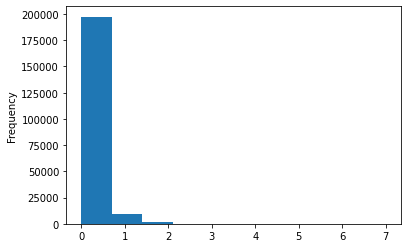

In [33]:
data_train_sentence.annotationCount.plot.hist() # most of the sentences has no annotation

In [34]:
data_train_sentence.annotationCount.value_counts()

0    197398
1      9100
2      1627
3       283
4        49
5        24
6        12
7         4
Name: annotationCount, dtype: int64

In [35]:
# data_train_sentence[data_train_sentence.annotationCount>6]

# Train/Test Split

In [36]:
data_train_sentence['positiveExample'] = data_train_sentence.annotationCount>0
x = data_train_sentence.positiveExample.value_counts().reset_index()
x['percentage'] = x.positiveExample/x.positiveExample.sum()
x

,index,positiveExample,percentage
0,False,197398,0.946767
1,True,11099,0.053233


In [37]:
data_train_sentence[data_train_sentence.positiveExample].feature_text.value_counts()

Female                                                                  683
Male                                                                    288
anxious-OR-nervous                                                      213
Difficulty-with-sleep                                                   201
35-year                                                                 199
heavy-periods-OR-irregular-periods                                      199
20-year                                                                 198
17-year                                                                 195
Episodes-of-heart-racing                                                165
Nausea                                                                  163
Irregular-menses                                                        156
heart-pounding-OR-heart-racing                                          144
symptoms-for-6-months                                                   136
Adderall-use

Use a train/test split of 20%  
Only strata with more than 50 cases will be included for test  

In [38]:
data_train_sentence['split'] = None

In [39]:
rng = default_rng(12345)

def sampling(group, testProb=0.2, minGroupSize=50):
    if len(group)<minGroupSize:
        return np.array(list(repeat('train', len(group)))) # all use in train
    else:
        return rng.choice(
            ['train', 'test'], size=len(group),
            replace=True, p=[1-testProb, testProb],
            
        )
data_train_sentence.loc[data_train_sentence.positiveExample, 'split'] = data_train_sentence[data_train_sentence.positiveExample].groupby('feature_text').feature_num.transform(sampling)

In [40]:
data_train_sentence.loc[~data_train_sentence.positiveExample, 'split'] = data_train_sentence[~data_train_sentence.positiveExample].groupby(
    'feature_text').feature_num.transform(
    partial(sampling, testProb=0.1)
)

In [41]:
display((data_train_sentence.split.isna().sum(),'number na split'))
data_train_sentence[['positiveExample', 'split']].value_counts()

(0, 'number na split')

positiveExample  split
False            train    177514
                 test      19884
True             train      9092
                 test       2007
dtype: int64

In [42]:
data_train_sentence.sample(10)

,feature_num,feature_text,pn_history_sentences,pn_history_sentences_annotationLocation,annotationParsedFromSentenceAnnotation,annotationCount,positiveExample,split
146723,702,heavy-periods-OR-irregular-periods,10 pound weight gain with poor diet.,[],[],0,False,train
161914,806,Difficulty-falling-asleep,"She lost her son three weeks ago, and since then she has been experiencing problems with sleep, depressed mood (""devastated""), loss of interest in scrapbooking.",[],[],0,False,test
147796,706,Infertility-HX-OR-Infertility-history,"sexual hx- active w/ boyfriend, irregular condom use.",[],[],0,False,train
80192,314,Nausea,"Has also noted some darkening of his stool over the past few weeks, but no frank blood.",[],[],0,False,train
200547,915,No-known-illness-contacts,PMH: negative.,[],[],0,False,train
116916,500,Onset-5-years-ago,"Denies sleeping difficulties, sadness, guilt,worthlessness, suicidal thoughts, denies appetite,bowel,weight,urinary changes,cold/hot intolerance,loc,headache, dizziness.",[],[],0,False,train
138091,603,Recent-upper-respiratory-symptoms,"He denies shortness of breath, N/V/C/D, lumps/bumps, abdominal pain. .",[],[],0,False,train
133328,610,No-relief-with-asthma-inhaler,FH: Father - asthma and hypercholesterimia; Mother healthy; brother healthy.,[],[],0,False,train
129246,606,Chest-pain,Tylenol and albuterol have not relieved his symptoms.,[],[],0,False,train
114262,511,Episodes-last-15-to-30-minutes,She denies chest pain but she has also been short of breath during these episodes.,[],[],0,False,train


In [43]:
data_train_sentence.to_csv('data_train_sentence.csv', index=False)

# Sentence Tokenize all the notes for future pre-training  value_counts

In [44]:
tqdm().pandas()
data_patient_notes['pn_history_processed'] = data_patient_notes.pn_history.progress_apply(subRN)
data_patient_notes_sentences = data_patient_notes.pn_history_processed.progress_apply(sentenceTokenizer)

0it [00:00, ?it/s]

  0%|          | 0/42146 [00:00<?, ?it/s]

  0%|          | 0/42146 [00:00<?, ?it/s]

In [45]:
data_patient_notes_sentences = pd.concat(list(pd.DataFrame({'sentence': i}) for i in data_patient_notes_sentences))
print(data_patient_notes_sentences.shape)
data_patient_notes_sentences.head()

(608811, 1)


,sentence
0,"17-year-old male, has come to the student health clinic complaining of heart pounding."
1,"Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment."
2,"began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav."
3,"associated with dispnea on exersion and rest,stressed out about school."
4,reports fe feels like his heart is jumping out of his chest.


In [46]:
data_patient_notes_sentences.sample(20)

,sentence
1,Reports heavier periods in the last 6 months and she changes pads/tampons every couple of hours.
2,Began as 2/10 and now is 8/10.
1,HPI: Mrs. Montgomery is a 44 y.o female with CC of irregular periods.
20,"Social hx - 1-2 beers on weekend, Non smoker, Sexually active with girlfriend, uses protection, 1 use of marijuana reported, University Student, good social supports."
13,"LMP 2 days ago, regular."
11,he smokes about 1/2-1 pack of cigarettes per day for the past 20 years.
14,allergies: none.
10,PSH/trauma/travel none.
6,ROS: as above.
3,Her son passed in a motor vehicle accident three weeks ago and thoughts of him keep her up at night.


In [47]:
data_patient_notes_sentences.to_csv('patient_notes_sentences.csv', index=False)

# Saving a copy of emilyalsentzer/Bio_ClinicalBERT

In [48]:
pip install sentence_transformers

     |████████████████████████████████| 79 kB 3.0 MB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120748 sha256=2537fc339e81bfb3bf87f057c31ee4b39e53c66533547dd5d07cc857ce8fb49e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [49]:
from sentence_transformers import SentenceTransformer

In [50]:
model = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
model.save('models/emilyalsentzer_Bio_ClinicalBERT')